In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import scipy.stats
import collections
import seaborn
import statsmodels.stats.proportion
import matplotlib

seaborn.set_style("darkgrid")
plt.rcParams.update({"font.size": 24})

## Read Data

In [2]:
# read data

raw_df = pd.read_csv("raw_Mar31.csv", index_col=None)
for i, column in enumerate(raw_df.columns):
    end = "\n" if i % 5 == 0 and i > 0 else "\t"
    print(f"{column:30s}", end=end)
print()
print(f"total number of rows = {raw_df.shape[0]}")
n_videos = raw_df["Filename"].str.endswith(".mp4").sum()
n_videos_rp = ((raw_df != -1).all(axis=1) & raw_df["Filename"].str.endswith(".mp4")).sum()
print(f"total number of videos = {n_videos}")
print(f"total number of videos with RP output = {n_videos_rp}")

Filename                      	Advertiser                    	Date                          	Version                       	Country                       	Duration                      
Description                   	Brand/Product                 	ProductAdvertiser             	Title                         	Creative ID                   
Channel                       	Publication                   	Website                       	!!MISSING_KEY!! CreativeLabel_Outlet_PaidSocial	Ad Format                     
Endline                       	video_key                     	frames_analyzed               	(female, [0, 15), [-inf, 1.1))	(female, [0, 15), [1.1, 2.1)) 
(female, [0, 15), [2.1, 3.1)) 	(female, [0, 15), [3.1, 4.1)) 	(female, [0, 15), [4.1, 5.1)) 	(female, [0, 15), [5.1, 6.1)) 	(female, [0, 15), [6.1, 7.1)) 
(female, [0, 15), [7.1, 8.1)) 	(female, [0, 15), [8.1, 9.1)) 	(female, [15, 25), [-inf, 1.1))	(female, [15, 25), [1.1, 2.1))	(female, [15, 25), [2.1, 3.1))
(female, [15, 25), [3

## Filter Data

In [3]:
# filter data

data_df = raw_df.loc[(raw_df != -1).all(axis=1) & raw_df["Filename"].str.endswith(".mp4")].copy()
data_df.index = pd.RangeIndex(0, len(data_df))
print(data_df.shape)

(7648, 148)


## Check Data

In [4]:
# check cross section bins count equals aggregates

def describe(row):
    print(row["Creative ID"])
    rp_columns = [column for column in row.index if re.match(r"\((fe)?male", column)]
    for column in rp_columns:
        if row[column] != 0:
            print(f"\t{column} : {row[column]}")
    print(f"faces : {row.faces}")
    print(f"gender : male = {row.masculine_faces}, female = {row.feminine_faces}")
    print("age : ")
    for j in range(7):
        count = row[f"age_{j + 1}"]
        end = ", " if j < 6 else "\n"
        print(f"age_{j + 1} = {count}", end=end)
    print("monk skin tone : ")
    for k in range(10):
        count = row[f"mst_scale_{k + 1}"]
        end = ", " if k < 9 else "\n"
        print(f"mst_scale_{k + 1} = {count}", end=end)

for _, row in data_df.iterrows():
    rp_data = np.zeros((2, 7, 10), dtype=int)
    for i, gender in enumerate(["male", "female"]):
        for j in range(7):
            for k in range(10):
                age_lb = 0 if j == 0 else 10 * j + 5
                age_ub = 10 * j + 15
                mst_lb = "-inf" if k == 0 else k + 0.1
                mst_ub = k + 1.1
                column_name = f"({gender}, [{age_lb}, {age_ub}), [{mst_lb}, {mst_ub}))"
                if column_name in row:
                    rp_data[i, j, k] = row[column_name]
    assert rp_data.sum() == row["faces"]
    assert rp_data[0].sum() == row["masculine_faces"]
    assert rp_data[1].sum() == row["feminine_faces"]
    for j in range(7):
        assert rp_data[:,j].sum() == row[f"age_{j + 1}"]
    # for k in range(10):
    #     assert rp_data[:, :, k].sum() == row[f"mst_scale_{k + 1}"]

## Metadata Distributions

In [4]:
def target_gender(desc):
    desc = str(desc)
    f = re.search(r"(^|\s)(females?)|(wom(a|e)n)(\s|$)", desc.lower()) is not None
    m = re.search(r"(^|\s)((?<!fe)males?)|((?<!wo)m(a|e)n)(\s|$)", desc.lower()) is not None
    u = re.search(r"(^|\s)unisex(\s|$)", desc.lower()) is not None
    if f and not m and not u:
        return "female"
    elif m and not f:
        return "male"
    elif u and not f and not m:
        return "unisex"
    else:
        return "unspecified"

# metadata

data_df["country"] = data_df["Country"]
data_df["brand"] = data_df["ProductAdvertiser"]
data_df["product type"] = data_df["brand_category"]
# data_df.loc[data_df["Brand/Product"].apply(lambda x: re.search("(\s|^)((toiletries)|(toilet))(\s|$)", x) is not None), 
#             "product type"] = "toiletries"

# brand: MNY = MAYBELLINE
data_df["brand"] = data_df["brand"].str.replace("^MAYBELLINE$", "MNY")
data_df["product target gender"] = data_df["Brand/Product"].apply(target_gender)

/var/folders/r0/x3cynkz966z2t0k946xpqqsc0000gn/T/ipykernel_1789/3934675033.py:24: FutureWarning: The default value of regex will change from True to False in a future version.
  data_df["brand"] = data_df["brand"].str.replace("^MAYBELLINE$", "MNY")


In [5]:
def plural(metadata):
    if metadata == "country":
        return "countries"
    elif metadata == "brand":
        return "brands"
    elif metadata == "product type":
        return "product types"
    elif metadata == "product target gender":
        return "product target gender categories"
    else:
        return metadata + "s"

def plot_metadata_distribution(dist, metadata):
    plt.figure(figsize=(22, 10))
    x = [item[0] for item in dist]
    y = [item[1] for item in dist]
    total = sum(y)
    yper = [100*yy/total for yy in y]
    xx = np.arange(len(x))
    bc = plt.bar(xx, y, width=0.8, edgecolor="black", linewidth=2)
    plt.bar_label(bc, [f"{yy:.1f}%" for yy in yper], padding=10, rotation=0)
    bottom, top = plt.ylim()
    plt.ylim(bottom, top + 50)
    xrotation = 90 if len(x) > 12 else 0
    plt.xticks(xx, x, rotation=xrotation, ha="center", fontsize="small")
    plt.yticks(fontsize="small")
    plt.xlabel(metadata.upper())
    plt.ylabel("NUMBER OF ADS")
    metadata_in_title = plural(metadata)
    plt.title(f"DISTRIBUTION OF ADS ACROSS {metadata_in_title.upper()}")
    plt.savefig(f"plots/metadata/{metadata}.png", bbox_inches="tight", pad_inches=0, dpi=300)
    plt.close()

country_dist = sorted(collections.Counter(data_df["country"]).items(), key=lambda x: x[1], reverse=True)
brand_dist = sorted(collections.Counter(data_df["brand"]).items(), key=lambda x: x[1], reverse=True)
producttype_dist = sorted(collections.Counter(data_df["product type"]).items(), key=lambda x: x[1], reverse=True)
targetgender_dist = sorted(collections.Counter(data_df["product target gender"]).items(), key=lambda x: x[1], 
                           reverse=True)
total = len(data_df)

print("country")
for i, (country, count) in enumerate(country_dist):
    per = 100*count/total
    end = "\n" if i % 5 == 0 and i > 0 else "\t"
    print(f"{country:10s} : {count:4d} ({per:4.1f}%)", end=end)
plot_metadata_distribution(country_dist, "country")
print("\n")

print("brand")
for i, (brand, count) in enumerate(brand_dist):
    per = 100*count/total
    end = "\n" if i % 5 == 0 and i > 0 else "\t"
    print(f"{brand:10s} : {count:4d} ({per:4.1f}%)", end=end)
plot_metadata_distribution(brand_dist, "brand")
print("\n")

print("product type")
for i, (producttype, count) in enumerate(producttype_dist):
    per = 100*count/total
    end = "\n" if i % 5 == 0 and i > 0 else "\t"
    print(f"{producttype:10s} : {count:4d} ({per:4.1f}%)", end=end)
plot_metadata_distribution(producttype_dist, "product type")
print("\n")

print("product target gender")
for i, (targetgender, count) in enumerate(targetgender_dist):
    per = 100*count/total
    end = "\n" if i % 5 == 0 and i > 0 else "\t"
    print(f"{targetgender:10s} : {count:4d} ({per:4.1f}%)", end=end)
plot_metadata_distribution(targetgender_dist, "product target gender")

/tmp/ipykernel_34980/3578326182.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  data_df["brand"] = data_df["brand"].str.replace("^MAYBELLINE$", "MNY")


country
Germany    : 3202 (41.9%)	UK         : 1715 (22.4%)	France     :  817 (10.7%)	Italy      :  806 (10.5%)	USA        :  701 ( 9.2%)	Spain      :  227 ( 3.0%)
Brazil     :   54 ( 0.7%)	India      :   49 ( 0.6%)	Mexico     :   46 ( 0.6%)	Indonesia  :   30 ( 0.4%)	Canada     :    1 ( 0.0%)


brand
GARNIER    : 1825 (23.9%)	OAP        :  880 (11.5%)	MNY        :  754 ( 9.9%)	LRP        :  631 ( 8.3%)	YSL        :  613 ( 8.0%)	VICHY      :  511 ( 6.7%)
LANCOME    :  504 ( 6.6%)	KIEHLS     :  429 ( 5.6%)	ARMANI     :  337 ( 4.4%)	KERASTASE  :  335 ( 4.4%)	NYX        :  286 ( 3.7%)
CERAVE     :  239 ( 3.1%)	LOP        :  110 ( 1.4%)	PRADA      :   84 ( 1.1%)	BIOTHERM   :   80 ( 1.0%)	REDKEN     :   30 ( 0.4%)


product type
makeup     : 2897 (37.9%)	skincare   : 2429 (31.8%)	haircare   : 1640 (21.4%)	fragrance  :  682 ( 8.9%)	

product target gender
unspecified : 4844 (63.3%)	female     : 2155 (28.2%)	male       :  460 ( 6.0%)	unisex     :  189 ( 2.5%)	

In [6]:
def metadata_x_metadata_stacked(data_df, primary_metadata, secondary_metadata, figsize=(22, 10)):
    assert primary_metadata in ["brand", "country", "product type", "product target gender"]
    assert secondary_metadata in ["brand", "country", "product type", "product target gender"]
    n_primary_metadata_cats = data_df[primary_metadata].unique().size
    primary_metadata_dist = collections.Counter(data_df[primary_metadata].tolist())
    primary_metadata_cats = sorted(primary_metadata_dist.keys(), key=lambda cat: primary_metadata_dist[cat], 
                                   reverse=True)
    n_secondary_metadata_cats = data_df[secondary_metadata].unique().size
    secondary_metadata_dist = collections.Counter(data_df[secondary_metadata].tolist())
    secondary_metadata_cats = sorted(secondary_metadata_dist.keys(), key=lambda cat: secondary_metadata_dist[cat], 
                                   reverse=True)
    metadata_x_metadata_arr = np.zeros((n_primary_metadata_cats, n_secondary_metadata_cats), dtype=int)
    for (primary_metadata_cat, secondary_metadata_cat), df in data_df.groupby([primary_metadata, secondary_metadata]):
        i = primary_metadata_cats.index(primary_metadata_cat)
        j = secondary_metadata_cats.index(secondary_metadata_cat)
        metadata_x_metadata_arr[i, j] = len(df)
    metadata_x_metadata_arr = 100 * metadata_x_metadata_arr / metadata_x_metadata_arr.sum(axis=1, keepdims=True)
    bar_width = 0.8
    bottom = np.zeros(n_primary_metadata_cats, dtype=float)
    x = np.arange(n_primary_metadata_cats)
    plt.figure(figsize=figsize)
    for j, secondary_metadata_cat in enumerate(secondary_metadata_cats):
        height = metadata_x_metadata_arr[:, j]
        plt.bar(x, height, width=bar_width, bottom=bottom, label=secondary_metadata_cat, edgecolor="black", lw=2)
        bottom += height
    plt.legend(bbox_to_anchor=(1, 1))
    xrotation = 90 if n_primary_metadata_cats > 12 else 0
    plt.xticks(x, primary_metadata_cats, fontsize="small", rotation=xrotation)
    plt.xlabel(primary_metadata)
    plt.ylabel("PERCENTAGE OF ADS")
    plt.title(f"{secondary_metadata.upper()} DISTRIBUTION OF {primary_metadata.upper()} ADS")
    plt.savefig(f"plots/metadata_x_metadata/{primary_metadata}_x_{secondary_metadata}.png", bbox_inches="tight", 
                pad_inches=0, dpi=300)
    plt.close()

In [7]:
metadata_x_metadata_stacked(data_df, "brand", "product type")
metadata_x_metadata_stacked(data_df, "country", "product type")
metadata_x_metadata_stacked(data_df, "brand", "product target gender")
metadata_x_metadata_stacked(data_df, "country", "product target gender")
metadata_x_metadata_stacked(data_df, "product type", "product target gender")
metadata_x_metadata_stacked(data_df, "brand", "country", figsize=(22, 15))
metadata_x_metadata_stacked(data_df, "country", "brand", figsize=(22, 15))

## Create Data

In [5]:
# rp_data rows x gender x age x skin tone

gender_cats = ["male", "female"]
age_cats = [(0, 15), (15, 25), (25, 35), (35, 45), (45, 55), (55, 65), (65, 75)]
age_cats2 = ["<15y", "15y-25y", "25y-35y", "35y-45y", "45-75y"]
skintone_cats = [(-np.inf, 1.1), (1.1, 2.1), (2.1, 3.1), (3.1, 4.1), (4.1, 5.1),
                 (5.1, 6.1), (6.1, 7.1), (7.1, 8.1), (8.1, 9.1), (9.1, 10.1)]
skintone_cats2 = ["light", "medium", "dark"]

rp_data = np.zeros((len(data_df), len(gender_cats), len(age_cats), len(skintone_cats)), dtype=int)

for i, row in data_df.iterrows():
    for j, gender in enumerate(gender_cats):
        for k, age_bin in enumerate(age_cats):
            age_lb, age_ub = age_bin
            for l, skintone_bin in enumerate(skintone_cats):
                skintone_lb, skintone_ub = skintone_bin
                column = f"({gender}, [{age_lb}, {age_ub}), [{skintone_lb}, {skintone_ub}))"
                if column in row.index:
                    rp_data[i, j, k, l] += row[column]

rp_data2 = np.zeros((len(data_df), len(gender_cats), len(age_cats2), len(skintone_cats2)), dtype=int)
rp_data2[:, :, :4, 0] = rp_data[:, :, :4, :3].sum(axis=3)
rp_data2[:, :, :4, 1] = rp_data[:, :, :4, 3:7].sum(axis=3)
rp_data2[:, :, :4, 2] = rp_data[:, :, :4, 7:].sum(axis=3)
rp_data2[:, :, 4, 0] = rp_data[:, :, 4:, :3].sum(axis=(2,3))
rp_data2[:, :, 4, 1] = rp_data[:, :, 4:, 3:7].sum(axis=(2, 3))
rp_data2[:, :, 4, 2] = rp_data[:, :, 4:, 7:].sum(axis=(2,3))

## Skintone 10

In [6]:
skintone_data = rp_data.sum(axis=(1,2))
print(skintone_data.shape)

(7648, 10)


In [17]:
y = skintone_data/skintone_data.sum(axis=1, keepdims=True)
y = np.mean(100*y, axis=0)

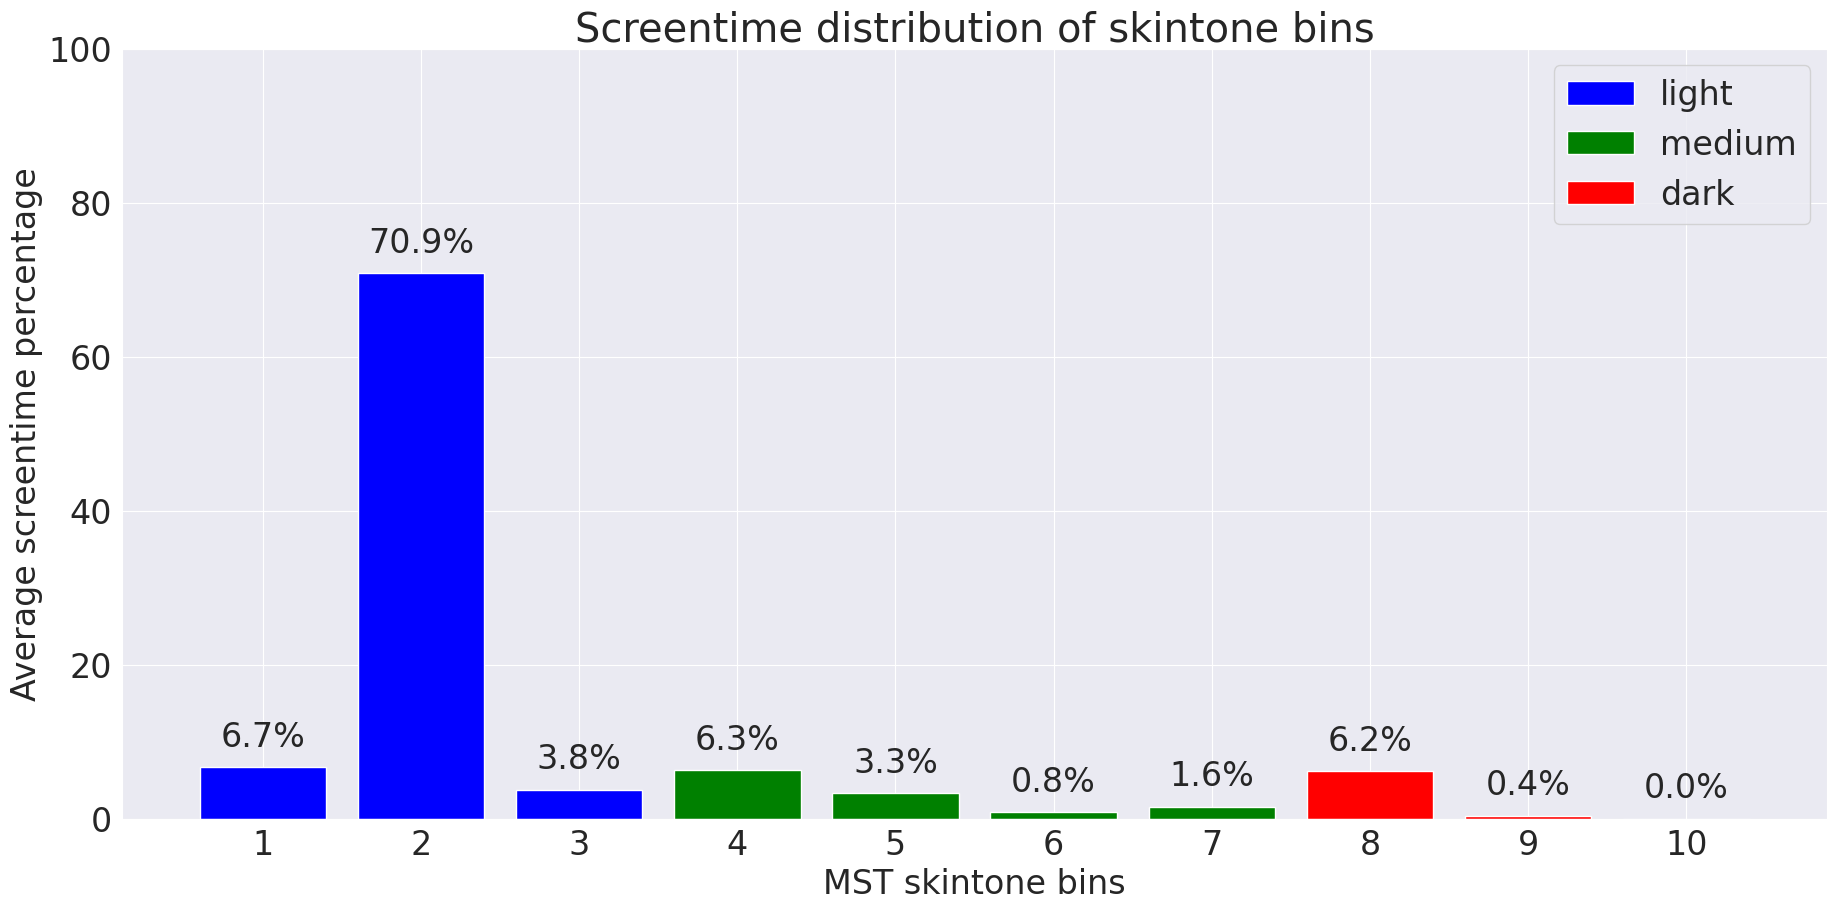

In [38]:
x = np.arange(1, 11)
plt.figure(figsize=(22, 10))
bc = plt.bar(x, y, width=0.8, color=["b", "b", "b", "g", "g", "g", "g", "r", "r", "r"])
plt.bar_label(bc, [f"{yy:.1f}%" for yy in y], padding=10)
plt.title("Screentime distribution of skintone bins")
plt.xlabel("MST skintone bins")
plt.ylabel("Average screentime percentage")
plt.xticks(x, x)
plt.ylim(0, 100)
plt.legend([bc.patches[0], bc.patches[3], bc.patches[7]], ["light", "medium", "dark"])
plt.savefig("plots/skintone10.png", bbox_inches="tight", pad_inches=0, dpi=300)

In [33]:
skintone_data2 = rp_data2.sum(axis=(1,2))
print(skintone_data2.shape)

(7648, 3)


In [34]:
y2 = skintone_data2/skintone_data2.sum(axis=1, keepdims=True)
y2 = np.mean(100*y2, axis=0)
y2

array([81.39517347, 12.01032912,  6.59449741])

## Skintone 10 vs Brand, Country

In [7]:
rp_data.shape, data_df[["brand", "country"]].shape, data_df["brand"].unique().size, data_df["country"].unique().size

((7648, 2, 7, 10), (7648, 2), 16, 11)

In [18]:
skintone_data = rp_data.sum(axis=(1,2))
skintone_percentage = 100*(skintone_data/skintone_data.sum(axis=1, keepdims=True))

brand_arr = []
for brand in sorted(data_df["brand"].unique()):
    row = [brand, (data_df["brand"] == brand).sum()]
    for i in range(10):
        avg = skintone_percentage[data_df["brand"] == brand, i].mean()
        row.append(avg)
    brand_arr.append(row)
brand_skintone_df = pd.DataFrame(brand_arr, columns=["brand", "count"] + [f"MST {i}" for i in range(1, 11)])
brand_skintone_df.to_csv("skintone_vs_brand.csv", index=False)

country_arr = []
for country in sorted(data_df["country"].unique()):
    row = [country, (data_df["country"] == country).sum()]
    for i in range(10):
        avg = skintone_percentage[data_df["country"] == country, i].mean()
        row.append(avg)
    country_arr.append(row)
country_skintone_df = pd.DataFrame(country_arr, columns=["country", "count"] + [f"MST {i}" for i in range(1, 11)])
country_skintone_df.to_csv("skintone_vs_country.csv", index=False)

brand_x_country_arr = []
for brand in sorted(data_df["brand"].unique()):
    for country in sorted(data_df["country"].unique()):
        index = (data_df["brand"] == brand) & (data_df["country"] == country)
        count = index.sum()
        if count:
            row = [brand, country, count]
            for i in range(10):
                avg = skintone_percentage[index, i].mean()
                row.append(avg)
            brand_x_country_arr.append(row)
brand_x_country_df = pd.DataFrame(brand_x_country_arr, columns=["brand", "country", "count"]
                                   + [f"MST {i}" for i in range(1, 11)])
brand_x_country_df.to_csv("skintone_vs_brand_x_country.csv", index=False)

## Anti-Aging

In [6]:
f1 = data_df["Brand/Product"].str.lower().str.contains(r"age\Wperfect")
f2 = data_df["Brand/Product"].str.lower().str.contains(r"l\\?'?oreal")
f3 = (data_df["brand"] == "OAP")
f4 = data_df["Brand/Product"].str.lower().str.contains(r"revitalift\Wlaser")
f5 = data_df["Brand/Product"].str.lower().str.contains(r"revitalift\Wfiller")
f6 = data_df["Brand/Product"].str.lower().str.contains(r"gene|ifique")
f7 = (data_df["brand"] == "LANCOME")
print(f1.sum())
print(f4.sum())
print(f5.sum())
print(f6.sum())
print(f2.sum())
print(f3.sum())
print(f7.sum())
print((f1 & f2 & f3).sum())
print((f4 & f2 & f3).sum())
print((f5 & f2 & f3).sum())
print((f6 & f7).sum())

26
38
7
92
990
880
504
26
38
7
59


In [8]:
f8 = ((f1 | f4 | f5) & f2 & f3) | (f6 & f7)
f9 = ~f8 & (data_df["product type"] == "skincare")
data_df["anti-aging"] = 0
data_df.loc[f8, "anti-aging"] = 1
data_df.loc[f9 , "anti-aging"] = 2
collections.Counter(data_df["anti-aging"])

Counter({0: 5217, 2: 2301, 1: 130})

In [9]:
rp_data3 = rp_data2.sum(axis=(1,3))
print(rp_data3.shape)
rp_data3[:,0] = rp_data3[:,:3].sum(axis=1)
rp_data3[:,3] = rp_data3[:,3:].sum(axis=1)
rp_data3 = rp_data3[:,[0,3]]
print(rp_data3.shape)
print((rp_data2.sum(axis=(1,2,3)) == rp_data3.sum(axis=1)).all())

(7648, 5)
(7648, 2)
True


In [12]:
antiage_percentage = 100 * rp_data3/rp_data3.sum(axis=1, keepdims=True)
print(antiage_percentage.shape)

(7648, 2)


In [13]:
np.vstack((antiage_percentage[data_df["anti-aging"] == 2].mean(axis=0), 
           antiage_percentage[data_df["anti-aging"] == 1].mean(axis=0)))

array([[92.91565164,  7.08434836],
       [88.36937044, 11.63062956]])

In [14]:
x = antiage_percentage[data_df["anti-aging"] == 1, 0] # screen time of young people (<35) in ads of anti-aging products
y = antiage_percentage[data_df["anti-aging"] == 2, 0] # screen time of young people (<35) in ads of not anti-aging products
print(x.shape, x.mean(), y.shape, y.mean())
res = scipy.stats.ttest_ind(x, y, equal_var=False, alternative="less")
print(res.pvalue)

(130,) 88.36937044112939 (2301,) 92.91565164040503
0.018718255480776512


## Demographic Identity vs Metadata

In [9]:
# one metadata vs one rp

def metadata_x_rp(df, rp_data, metadata, rp, confidence=0.05, condition=None):
    assert rp in ["gender", "age", "skin tone"]
    assert metadata in ["country", "brand", "product type", "product target gender"]
    
    if condition is None:
        plot_filename = f"plots/rp_x_metadata/{rp}_x_{metadata}.png"
        text_filename = f"text/rp_x_metadata/{rp}_x_{metadata}.txt"
    else:
        plot_filename = f"plots/rp_x_metadata_x_metadata/{rp}_x_{metadata}_{condition}.png"
        text_filename = f"text/rp_x_metadata_x_metadata/{rp}_x_{metadata}_{condition}.txt"
    
    metadata_cat_to_count = collections.Counter(df[metadata])
    metadata_cats = [metadata_cat for metadata_cat, count in metadata_cat_to_count.items() if count >= 30]
    removed_metadata_cats = [x for x in df[metadata].unique() if x not in metadata_cats]
    if len(metadata_cats) <= 1:
        return
    
    title = f"{rp} vs {metadata}"
    if condition is not None:
        title += f" {condition}"
    
    
    print(title)
    print(f"{metadata} categories : {metadata_cats}")
    print(f"removed categories : {removed_metadata_cats}")
    
    fw = open(text_filename, "w")
    fw.write(f"{title}\n")
    fw.write(f"{metadata} cats = {metadata_cats}\n")
    fw.write(f"removed {metadata} cats = {removed_metadata_cats}\n")
    
    if rp == "gender":
        rp_cats = gender_cats
    elif rp == "age":
        rp_cats = age_cats2
    else:
        rp_cats = skintone_cats2
    
    rp_arr = np.zeros((df[metadata].isin(metadata_cats).sum(), len(rp_cats)))
    metadata_arr = []
    j = 0
    
    for i, row in df.iterrows():
        metadata_value = row[metadata]
        if metadata_value in metadata_cats:
            metadata_arr.append(metadata_value)
            if rp == "gender":
                rp_arr[j] = 100 * rp_data[i].sum(axis=(1, 2))/rp_data[i].sum()
            elif rp == "age":
                rp_arr[j] = 100 * rp_data[i].sum(axis=(0, 2))/rp_data[i].sum()
            else:
                rp_arr[j] = 100 * rp_data[i].sum(axis=(0, 1))/rp_data[i].sum()
            j += 1
    
    metadata_arr = np.array(metadata_arr)
    most_common_metadata_cat = rp_arr.sum(axis=0).argmax()
    metadata_cats = sorted(metadata_cats, key=lambda x: rp_arr[:, most_common_metadata_cat][metadata_arr == x].mean(), 
                           reverse=True)
    
    plt.figure(figsize=(22, 10))
    x = np.arange(len(metadata_cats))
    group_width = 0.8
    bar_width = group_width/len(rp_cats)

    for i, rp_cat in enumerate(rp_cats):
        rp_cat_arr = rp_arr[:, i]
        y = [rp_cat_arr[metadata_arr == metadata_cat].mean() for metadata_cat in metadata_cats]
        bc = plt.bar(x + i * bar_width, y, width=bar_width, label=str(rp_cat), edgecolor="black", linewidth=2)
        plt.bar_label(bc, [f"{yy:.1f}%" for yy in y], padding=5, rotation=90, fontsize="small")
    
    bottom, top = plt.ylim()
    plt.ylim(bottom, top + 10)
    plt.ylabel("AVERAGE SCREEN TIME")
    xrotation = 90 if len(x) > 10 else 0
    plt.xticks(x + bar_width*(len(rp_cats) - 1)/2, metadata_cats, ha="center", rotation=xrotation)
    plt.yticks(fontsize="small")
    plt.xlabel(metadata.upper())
    condition_title = " (" + condition + ")" if condition is not None else ""
    plt.title(f"DISTRIBUTION OF {rp.upper()} SCREEN TIME ACROSS {plural(metadata).upper()}{condition_title}")
    plt.legend()
    plt.savefig(plot_filename, bbox_inches="tight", pad_inches=0, dpi=300)
    plt.close()

    for i, rp_cat in enumerate(rp_cats):
        rp_cat_arr = rp_arr[:, i]
        metadata_to_rp_arr = {metadata_cat:rp_cat_arr[metadata_arr == metadata_cat] for metadata_cat in metadata_cats}
        metadata_sorted_by_mean = sorted(metadata_cats, key=lambda x: metadata_to_rp_arr[x].mean(), reverse=True)
        pvalues = []
        
        for j in range(len(metadata_cats) - 1):
            cat1, cat2 = metadata_sorted_by_mean[j], metadata_sorted_by_mean[j + 1]
            arr1, arr2 = metadata_to_rp_arr[cat1], metadata_to_rp_arr[cat2]
            _, pvalue = scipy.stats.ttest_ind(arr1, arr2, equal_var=False, alternative="greater")
            pvalues.append(pvalue)
        significant = np.array(pvalues)/(len(metadata_cats) - 1) < confidence
        print(f"{rp_cat} : ", end="")
        fw.write(f"{rp_cat}\n")
        
        for j in range(len(metadata_cats) - 1):
            cat = metadata_sorted_by_mean[j]
            sign = ">" if significant[j] else "="
            print(f"{cat} {sign} ", end="")
            fw.write(f"{cat} {sign} ")
        print(metadata_sorted_by_mean[-1])
        fw.write(f"{metadata_sorted_by_mean[-1]}\n")
    print()
    fw.write("\n")
    fw.close()

In [10]:
metadata_vars = ["country", "brand", "product type", "product target gender"]
rp_vars = ["gender", "age", "skin tone"]

for metadata in metadata_vars:
    for rp in rp_vars:
        metadata_x_rp(data_df, rp_data2, metadata, rp)

gender vs country
country categories : ['Mexico', 'Brazil', 'USA', 'France', 'Germany', 'Italy', 'Spain', 'UK', 'India', 'Indonesia']
removed categories : ['Canada']
male : India > UK > France > Germany > USA > Italy > Brazil > Mexico = Spain > Indonesia
female : Indonesia > Spain = Mexico > Brazil > Italy > USA > Germany > France > UK > India

age vs country
country categories : ['Mexico', 'Brazil', 'USA', 'France', 'Germany', 'Italy', 'Spain', 'UK', 'India', 'Indonesia']
removed categories : ['Canada']
<15y : Germany > USA > UK = Italy > Spain > France > Indonesia > Brazil > Mexico > India
15y-25y : Brazil > USA > Germany > France > UK > Italy > Indonesia = Spain > Mexico > India
25y-35y : India > Indonesia > Mexico > Spain > Italy > France > UK > Germany = Brazil > USA
35y-45y : Mexico > India > UK > Spain > France > Germany > Italy = USA > Brazil > Indonesia
45-75y : Germany > UK = France > Spain = Italy > Mexico > USA > India > Brazil > Indonesia

skin tone vs country
country cate

## Demographic Identity vs Metadata vs Metadata BarPlots

In [8]:
metadata_columns = ["country", "brand", "product type", "product target gender"]

for i in range(len(metadata_columns)):
    for j in range(i + 1, len(metadata_columns)):
        col1 = metadata_columns[i]
        col2 = metadata_columns[j]
        gdf = data_df.groupby([col1, col2]).count()["Creative ID"].reset_index().rename(columns={"Creative ID": "n"})
        print(f"{col1} x {col2}")
        n = (gdf.n >= 30).sum()
        gdf1 = gdf[gdf.n >= 30].groupby(col1).count()["n"].reset_index()
        n1 = (gdf1.n > 1).sum()
        cats1 = gdf1.loc[gdf1.n > 1, col1].values
        gdf2 = gdf[gdf.n >= 30].groupby(col2).count()["n"].reset_index()
        n2 = (gdf2.n > 1).sum()
        cats2 = gdf2.loc[gdf2.n > 1, col2].values
        print(f"{n} ({col1}, {col2}) pairs have atleast 30 samples")
        print(f"{n1} {col1}s have atleast 2 {col2}s with atleast 30 samples: {cats1}")
        print(f"{n2} {col2}s have atleast 2 {col1}s with atleast 30 samples: {cats2}")
        print()

country x brand
52 (country, brand) pairs have atleast 30 samples
6 countrys have atleast 2 brands with atleast 30 samples: ['France' 'Germany' 'Italy' 'Spain' 'UK' 'USA']
13 brands have atleast 2 countrys with atleast 30 samples: ['ARMANI' 'CERAVE' 'GARNIER' 'KERASTASE' 'KIEHLS' 'LANCOME' 'LOP' 'LRP'
 'MAYBELLINE' 'NYX' 'OAP' 'VICHY' 'YSL']

country x product type
26 (country, product type) pairs have atleast 30 samples
6 countrys have atleast 2 product types with atleast 30 samples: ['France' 'Germany' 'Italy' 'Spain' 'UK' 'USA']
4 product types have atleast 2 countrys with atleast 30 samples: ['fragrance' 'haircare' 'makeup' 'skincare']

country x product target gender
20 (country, product target gender) pairs have atleast 30 samples
6 countrys have atleast 2 product target genders with atleast 30 samples: ['France' 'Germany' 'Italy' 'Spain' 'UK' 'USA']
4 product target genders have atleast 2 countrys with atleast 30 samples: ['female' 'male' 'unisex' 'unspecified']

brand x product

In [11]:
def metadata2_x_rp(df, rp_data, metadata1, metadata2, rp, confidence=0.05):
    assert rp in ["gender", "age", "skin tone"]
    assert metadata1 in ["country", "brand", "product type", "product target gender"]
    assert metadata2 in ["country", "brand", "product type", "product target gender"]
    metadata1_cats = df[metadata1].unique()
    metadata2_cats = df[metadata2].unique()
    
    for metadata1_cat in metadata1_cats:
        index = df[metadata1] == metadata1_cat
        fdf = df[index].copy()
        fdf.index = pd.RangeIndex(0, len(fdf))
        metadata_x_rp(fdf, rp_data[index], metadata=metadata2, rp=rp, confidence=confidence, 
                      condition=f"{metadata1}={metadata1_cat}")
    
    for metadata2_cat in metadata2_cats:
        index = df[metadata2] == metadata2_cat
        fdf = df[index].copy()
        fdf.index = pd.RangeIndex(0, len(fdf))
        metadata_x_rp(fdf, rp_data[index], metadata=metadata1, rp=rp, confidence=confidence, 
                      condition=f"{metadata2}={metadata2_cat}")

In [12]:
metadata_vars = ["country", "brand", "product type", "product target gender"]
rp_vars = ["gender", "age", "skin tone"]

for i in range(len(metadata_vars)):
    for j in range(i + 1, len(metadata_vars)):
        for rp in rp_vars:
            metadata2_x_rp(data_df, rp_data2, metadata_vars[i], metadata_vars[j], rp)

gender vs brand country=USA
brand categories : ['ARMANI', 'CERAVE', 'GARNIER', 'MNY', 'NYX', 'OAP', 'YSL']
removed categories : ['KIEHLS', 'LANCOME', 'LRP', 'PRADA', 'REDKEN', 'VICHY']
male : CERAVE = YSL > OAP > ARMANI = MNY > GARNIER > NYX
female : NYX > GARNIER > MNY = ARMANI > OAP > YSL = CERAVE

gender vs brand country=France
brand categories : ['GARNIER', 'KIEHLS', 'LANCOME', 'LRP', 'MNY', 'OAP', 'VICHY']
removed categories : ['ARMANI', 'BIOTHERM', 'CERAVE', 'KERASTASE', 'LOP', 'NYX', 'PRADA', 'YSL']
male : KIEHLS > LRP = VICHY > GARNIER > LANCOME > OAP > MNY
female : MNY > OAP > LANCOME > GARNIER > VICHY = LRP > KIEHLS

gender vs brand country=Germany
brand categories : ['ARMANI', 'BIOTHERM', 'CERAVE', 'GARNIER', 'KERASTASE', 'KIEHLS', 'LANCOME', 'LOP', 'LRP', 'MNY', 'NYX', 'VICHY', 'YSL']
removed categories : ['PRADA', 'REDKEN']
male : VICHY > LRP > ARMANI > NYX > YSL > CERAVE > KERASTASE > GARNIER > KIEHLS > BIOTHERM > LANCOME > MNY > LOP
female : LOP > MNY > LANCOME > BIOTHER

## Gender x Metadata x Metadata HeatMap

In [13]:
def gender_heatmap(df, rp_data, metadata1, metadata2, alpha=0.05):
    seaborn.set_style("dark")
    assert metadata1 in ["country", "brand", "product type", "product target gender"]
    assert metadata2 in ["country", "brand", "product type", "product target gender"]
    metadata1_cats_dist = collections.Counter(df[metadata1])
    metadata2_cats_dist = collections.Counter(df[metadata2])
    metadata1_cats = np.array(sorted(metadata1_cats_dist.keys(), key=lambda cat: metadata1_cats_dist[cat], 
                                     reverse=True))
    metadata2_cats = np.array(sorted(metadata2_cats_dist.keys(), key=lambda cat: metadata2_cats_dist[cat], 
                                     reverse=True))
    count_arr = np.zeros((len(metadata1_cats), len(metadata2_cats)), dtype=int)
    for (metadata1_cat, metadata2_cat), gdf in df.groupby([metadata1, metadata2]):
        i = (metadata1_cats == metadata1_cat).nonzero()[0].item()
        j = (metadata2_cats == metadata2_cat).nonzero()[0].item()
        count_arr[i, j] = len(gdf)
    row_index = (count_arr >= 30).any(axis=1)
    metadata1_cats, count_arr = metadata1_cats[row_index], count_arr[row_index]
    column_index = (count_arr >= 30).any(axis=0)
    metadata2_cats, count_arr = metadata2_cats[column_index], count_arr[:, column_index]
    value_arr = np.zeros((len(metadata1_cats), len(metadata2_cats)), dtype=float)
    for i, metadata1_cat in enumerate(metadata1_cats):
        for j, metadata2_cat in enumerate(metadata2_cats):
            ind = (df[metadata1] == metadata1_cat) & (df[metadata2] == metadata2_cat)
            if count_arr[i, j] < 30:
                value_arr[i, j] = np.nan
            else:
                n_female_faces = rp_data[ind, 1].sum(axis=(1, 2))
                n_total_faces = rp_data[ind].sum(axis=(1, 2, 3))
                value_arr[i, j] = (n_female_faces/n_total_faces).mean()
                res = scipy.stats.ttest_1samp(n_female_faces/n_total_faces, 0.5, alternative="two-sided")
                pvalue = res.pvalue
                if pvalue >= alpha:
                    value_arr[i, j] = 1.5
    cmap = matplotlib.colormaps["RdBu"](np.linspace(0.2, 0.9, 100))
    cmap = matplotlib.colors.ListedColormap(cmap)
    cmap.set_under("none")
    cmap2 = matplotlib.colormaps["binary"]
    cmap2.set_over("none")
    height = len(metadata1_cats) * 1.2
    width = len(metadata2_cats)
    plt.figure(figsize=(width, height))
    ax = seaborn.heatmap(100*value_arr, cmap=cmap2, vmin=100, vmax=200, cbar=False, annot=False)
    value_arr[value_arr == 1.5] = np.nan
    seaborn.heatmap(100*value_arr, xticklabels=metadata2_cats, yticklabels=metadata1_cats, annot=True, fmt=".2f", 
                    linewidth=1, cmap=cmap, annot_kws={"fontsize":"xx-small"}, cbar=True, vmin=0, vmax=100, 
                    linecolor="black", ax=ax)
    ax.set_xticklabels(metadata2_cats, fontsize="xx-small")
    ax.set_yticklabels(metadata1_cats, fontsize="xx-small")
    cbar = ax.collections[1].colorbar
    cbar.ax.tick_params(labelsize="xx-small")
    ax.set_xlabel(metadata2.upper(), fontsize="xx-small")
    ax.set_ylabel(metadata1.upper(), fontsize="xx-small")
    ax.set_title(f"Female Screentime for {metadata1.upper()} x {metadata2.upper()}", fontsize="xx-small")
    filename = f"plots/rp_x_metadata_x_metadata/gender_x_{metadata1}_x_{metadata2}.png"
    figure = ax.get_figure()
    figure.savefig(filename, dpi=300, bbox_inches="tight")
    plt.close()

In [14]:
gender_heatmap(data_df, rp_data2, "country", "brand")
gender_heatmap(data_df, rp_data2, "product type", "brand")
gender_heatmap(data_df, rp_data2, "product type", "country")
gender_heatmap(data_df, rp_data2, "product target gender", "brand")
gender_heatmap(data_df, rp_data2, "product target gender", "country")
gender_heatmap(data_df, rp_data2, "product target gender", "product type")

## Age x Metadata x Metadata HeatMap

In [15]:
def age_heatmap(df, rp_data, metadata1, metadata2, alpha=0.05):
    seaborn.set_style("dark")
    rp_cats = ["0-15", "15-25", "25-35", "35-45", "45-75"]
    cmap_names = ["Wistia", "Blues", "Reds", "Greens", "Purples"]
    assert metadata1 in ["country", "brand", "product type", "product target gender"]
    assert metadata2 in ["country", "brand", "product type", "product target gender"]
    metadata1_cats_dist = collections.Counter(df[metadata1])
    metadata2_cats_dist = collections.Counter(df[metadata2])
    metadata1_cats = np.array(sorted(metadata1_cats_dist.keys(), key=lambda cat: metadata1_cats_dist[cat], 
                                     reverse=True))
    metadata2_cats = np.array(sorted(metadata2_cats_dist.keys(), key=lambda cat: metadata2_cats_dist[cat], 
                                     reverse=True))
    count_arr = np.zeros((len(metadata1_cats), len(metadata2_cats)), dtype=int)
    for (metadata1_cat, metadata2_cat), gdf in df.groupby([metadata1, metadata2]):
        i = (metadata1_cats == metadata1_cat).nonzero()[0].item()
        j = (metadata2_cats == metadata2_cat).nonzero()[0].item()
        count_arr[i, j] = len(gdf)
    row_index = (count_arr >= 30).any(axis=1)
    metadata1_cats, count_arr = metadata1_cats[row_index], count_arr[row_index]
    column_index = (count_arr >= 30).any(axis=0)
    metadata2_cats, count_arr = metadata2_cats[column_index], count_arr[:, column_index]

    height = len(metadata1_cats) * 1.5
    width = len(metadata2_cats) + 15
    plt.figure(figsize=(width, height))
    ax = plt.gca()

    grey_arr = np.zeros((len(metadata1_cats), len(metadata2_cats)), dtype=float)

    for age_cat in range(len(rp_cats) - 1, -1, -1):
        rp_cat, cmap_name = rp_cats[age_cat], cmap_names[age_cat]
        value_arr = np.zeros((len(metadata1_cats), len(metadata2_cats)), dtype=float)
        for i, metadata1_cat in enumerate(metadata1_cats):
            for j, metadata2_cat in enumerate(metadata2_cats):
                ind = (df[metadata1] == metadata1_cat) & (df[metadata2] == metadata2_cat)
                if count_arr[i, j] < 30:
                    value_arr[i, j] = grey_arr[i, j] = np.nan
                else:
                    n_age_faces = rp_data[ind, :, age_cat].sum(axis=(1, 2))
                    n_total_faces = rp_data[ind].sum(axis=(1, 2, 3))
                    value_arr[i, j] = (n_age_faces/n_total_faces).mean()
                    res = scipy.stats.ttest_1samp(n_age_faces/n_total_faces, 0.5, alternative="greater")
                    pvalue = res.pvalue
                    if pvalue >= alpha:
                        value_arr[i, j] = np.nan
                        grey_arr[i, j] = grey_arr[i, j] * grey_arr[i, j]
                    else:
                        grey_arr[i, j] = np.nan
        cmap = matplotlib.colormaps[cmap_name](np.linspace(0.3, 0.9, 100))
        cmap = matplotlib.colors.ListedColormap(cmap)
        seaborn.heatmap(100*value_arr, xticklabels=metadata2_cats, yticklabels=metadata1_cats, annot=True, fmt=".2f",
                        linewidth=2, cmap=cmap, annot_kws={"fontsize":"x-small"}, cbar=True, vmin=50, vmax=100, 
                        linecolor="black", ax=ax, cbar_kws={"fraction": 0.04, "pad": 0.025, "shrink": 0.75})
        cbar = ax.collections[len(rp_cats) - age_cat - 1].colorbar
        cbar.ax.tick_params(labelsize="xx-small")
        cbar.ax.set_ylabel(f"{rp_cat}y", fontsize="xx-small")
    
    binary_cmap = matplotlib.colormaps["binary"]
    grey_arr[grey_arr == 0] = 0.5
    seaborn.heatmap(grey_arr, cmap=binary_cmap, cbar=False, annot=False, vmin=0, vmax=1, ax=ax, linewidths=2, 
                    linecolor="black")

    ax.set_xticklabels(metadata2_cats, fontsize="x-small")
    ax.set_yticklabels(metadata1_cats, fontsize="x-small")
    ax.set_xlabel(metadata2.upper(), fontsize="x-small")
    ax.set_ylabel(metadata1.upper(), fontsize="x-small")
    ax.set_title(f"Age Screentime for {metadata1.upper()} x {metadata2.upper()}", fontsize="x-small")
    filename = f"plots/rp_x_metadata_x_metadata/age_x_{metadata1}_x_{metadata2}.png"
    figure = ax.get_figure()
    figure.savefig(filename, dpi=300, bbox_inches="tight")
    plt.close()

In [16]:
age_heatmap(data_df, rp_data2, "country", "brand")
age_heatmap(data_df, rp_data2, "product type", "brand")
age_heatmap(data_df, rp_data2, "product type", "country")
age_heatmap(data_df, rp_data2, "product target gender", "brand")
age_heatmap(data_df, rp_data2, "product target gender", "country")
age_heatmap(data_df, rp_data2, "product target gender", "product type")

## Skin Tone x Metadata x Metadata HeatMap

In [17]:
def skin_tone_heatmap(df, rp_data, metadata1, metadata2, alpha=0.05):
    seaborn.set_style("dark")
    rp_cats = ["light", "medium", "dark"]
    cmap_names = ["Blues", "Wistia", "Greens"]
    assert metadata1 in ["country", "brand", "product type", "product target gender"]
    assert metadata2 in ["country", "brand", "product type", "product target gender"]
    metadata1_cats_dist = collections.Counter(df[metadata1])
    metadata2_cats_dist = collections.Counter(df[metadata2])
    metadata1_cats = np.array(sorted(metadata1_cats_dist.keys(), key=lambda cat: metadata1_cats_dist[cat], 
                                     reverse=True))
    metadata2_cats = np.array(sorted(metadata2_cats_dist.keys(), key=lambda cat: metadata2_cats_dist[cat], 
                                     reverse=True))
    count_arr = np.zeros((len(metadata1_cats), len(metadata2_cats)), dtype=int)
    for (metadata1_cat, metadata2_cat), gdf in df.groupby([metadata1, metadata2]):
        i = (metadata1_cats == metadata1_cat).nonzero()[0].item()
        j = (metadata2_cats == metadata2_cat).nonzero()[0].item()
        count_arr[i, j] = len(gdf)
    row_index = (count_arr >= 30).any(axis=1)
    metadata1_cats, count_arr = metadata1_cats[row_index], count_arr[row_index]
    column_index = (count_arr >= 30).any(axis=0)
    metadata2_cats, count_arr = metadata2_cats[column_index], count_arr[:, column_index]

    height = len(metadata1_cats) * 1.2
    width = len(metadata2_cats) + 10
    plt.figure(figsize=(width, height))
    ax = plt.gca()

    grey_arr = np.zeros((len(metadata1_cats), len(metadata2_cats)), dtype=float)

    for skin_tone_cat in range(len(rp_cats) - 1, -1, -1):
        rp_cat, cmap_name = rp_cats[skin_tone_cat], cmap_names[skin_tone_cat]
        value_arr = np.zeros((len(metadata1_cats), len(metadata2_cats)), dtype=float)
        for i, metadata1_cat in enumerate(metadata1_cats):
            for j, metadata2_cat in enumerate(metadata2_cats):
                ind = (df[metadata1] == metadata1_cat) & (df[metadata2] == metadata2_cat)
                if count_arr[i, j] < 30:
                    value_arr[i, j] = grey_arr[i, j] = np.nan
                else:
                    n_skin_tone_faces = rp_data[ind, :, :, skin_tone_cat].sum(axis=(1, 2))
                    n_total_faces = rp_data[ind].sum(axis=(1, 2, 3))
                    value_arr[i, j] = (n_skin_tone_faces/n_total_faces).mean()
                    res = scipy.stats.ttest_1samp(n_skin_tone_faces/n_total_faces, 0.5, alternative="greater")
                    pvalue = res.pvalue
                    if pvalue >= alpha:
                        value_arr[i, j] = np.nan
                        grey_arr[i, j] = grey_arr[i, j] * grey_arr[i, j]
                    else:
                        grey_arr[i, j] = np.nan
        cmap = matplotlib.colormaps[cmap_name](np.linspace(0.2, 0.9, 100))
        cmap = matplotlib.colors.ListedColormap(cmap)
        seaborn.heatmap(100*value_arr, xticklabels=metadata2_cats, yticklabels=metadata1_cats, annot=True, fmt=".2f",
                        linewidth=1, cmap=cmap, annot_kws={"fontsize":"xx-small"}, cbar=True, vmin=50, vmax=100, 
                        linecolor="black", ax=ax, cbar_kws={"fraction": 0.04, "pad": 0.025, "shrink": 0.75})
        cbar = ax.collections[len(rp_cats) - skin_tone_cat - 1].colorbar
        cbar.ax.tick_params(labelsize="xx-small")
        cbar.ax.set_ylabel(f"{rp_cat}", fontsize="xx-small")

    binary_cmap = matplotlib.colormaps["binary"]
    grey_arr[grey_arr == 0] = 0.5
    seaborn.heatmap(grey_arr, cmap=binary_cmap, cbar=False, annot=False, vmin=0, vmax=1, ax=ax, linewidths=2, 
                    linecolor="black")

    ax.set_xticklabels(metadata2_cats, fontsize="xx-small")
    ax.set_yticklabels(metadata1_cats, fontsize="xx-small")
    ax.set_xlabel(metadata2.upper(), fontsize="xx-small")
    ax.set_ylabel(metadata1.upper(), fontsize="xx-small")
    ax.set_title(f"Skin Tone Screentime for {metadata1.upper()} x {metadata2.upper()}", fontsize="xx-small")
    filename = f"plots/rp_x_metadata_x_metadata/skin_tone_x_{metadata1}_x_{metadata2}.png"
    figure = ax.get_figure()
    figure.savefig(filename, dpi=300, bbox_inches="tight")
    plt.close()

In [18]:
skin_tone_heatmap(data_df, rp_data2, "country", "brand")
skin_tone_heatmap(data_df, rp_data2, "product type", "brand")
skin_tone_heatmap(data_df, rp_data2, "product type", "country")
skin_tone_heatmap(data_df, rp_data2, "product target gender", "brand")
skin_tone_heatmap(data_df, rp_data2, "product target gender", "country")
skin_tone_heatmap(data_df, rp_data2, "product target gender", "product type")

## Target Gender x Metadata x Metadata HeatMap

In [19]:
def target_gender_metadata_x_metadata_heatmap(data_df, metadata1, metadata2):
    seaborn.set_style("dark")
    metadata1_cats_dist = collections.Counter(data_df[metadata1])
    metadata1_cats = filter(lambda cat: metadata1_cats_dist[cat] >= 30, metadata1_cats_dist.keys())
    metadata1_cats = sorted(metadata1_cats, key=lambda cat: metadata1_cats_dist[cat], reverse=True)
    metadata2_cats_dist = collections.Counter(data_df[metadata2])
    metadata2_cats = filter(lambda cat: metadata2_cats_dist[cat] >= 30, metadata2_cats_dist.keys())
    metadata2_cats = sorted(metadata2_cats, key=lambda cat: metadata2_cats_dist[cat], reverse=True)
    target_gender_cats = sorted(data_df["product target gender"].unique())
    value_arr = np.zeros((len(metadata1_cats), len(metadata2_cats), len(target_gender_cats)), dtype=int)
    for (metadata1_cat, metadata2_cat, target_gender_cat), df in data_df.groupby([metadata1, metadata2, 
                                                                                  "product target gender"]):
        if metadata1_cat in metadata1_cats and metadata2_cat in metadata2_cats:
            i, j, k = (metadata1_cats.index(metadata1_cat), metadata2_cats.index(metadata2_cat), 
                       target_gender_cats.index(target_gender_cat))
            value_arr[i, j, k] = len(df)
    count_arr = value_arr.sum(axis=2)
    arr = value_arr/(1e-8 + value_arr.sum(axis=2, keepdims=True))
    arr[value_arr == 0] = 0
    arr[count_arr < 30] = np.nan
    cmap_names = ["Reds", "Blues", "Greens", "Wistia"]
    plt.figure(figsize=(50, 20))
    for i, target_gender_cat in enumerate(target_gender_cats):
        ax = plt.subplot(2, 2, i + 1)
        heatmap_arr = arr[:, :, i]
        cmap = matplotlib.colormaps[cmap_names[i]](np.linspace(0.2, 0.9, 100))
        cmap = matplotlib.colors.ListedColormap(cmap)
        seaborn.heatmap(100*heatmap_arr, vmin=0, vmax=100, cmap=cmap, annot=True, fmt=".2f", linewidths=2, 
                        linecolor="black", xticklabels=metadata2_cats, yticklabels=metadata1_cats, ax=ax, cbar=True,
                        annot_kws={"fontsize": "x-small"}, cbar_kws={"shrink": 0.75, "fraction": 0.1, "pad": 0.05})
        ax.set_xticklabels(metadata2_cats, fontsize="xx-small")
        ax.set_yticklabels(metadata1_cats, fontsize="xx-small")
        ax.set_xlabel(metadata2.upper(), fontsize="xx-small")
        ax.set_ylabel(metadata1.upper(), fontsize="xx-small")
        ax.set_title(f"product target gender = {target_gender_cat.upper()} for {metadata1.lower()} x {metadata2.lower()}")
    plt.subplots_adjust(hspace=0.35, wspace=0.02)
    filename = f"plots/product_target_gender_metadata_x_metadata/product_target_gender_x_{metadata1}_x_{metadata2}"
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.close()

In [20]:
target_gender_metadata_x_metadata_heatmap(data_df, "product type", "brand")
target_gender_metadata_x_metadata_heatmap(data_df, "product type", "country")
target_gender_metadata_x_metadata_heatmap(data_df, "country", "brand")

In [52]:
def metadata_x_metadata_count(data_df, metadata1, metadata2):
    metadata1_cats = data_df[metadata1].unique()
    metadata2_cats = data_df[metadata2].unique()
    count = np.zeros((len(metadata1_cats), len(metadata2_cats)), dtype=int)
    for (metadata1_cat, metadata2_cat), gdf in data_df.groupby([metadata1, metadata2]):
        i = (metadata1_cats == metadata1_cat).nonzero()[0].item()
        j = (metadata2_cats == metadata2_cat).nonzero()[0].item()
        count[i, j] = len(gdf)
    count_df = pd.DataFrame(count, index=metadata1_cats, columns=metadata2_cats)
    display(count_df)

In [53]:
metadata_x_metadata_count(data_df, "product type", "brand")

,ARMANI,GARNIER,LANCOME,LRP,MNY,OAP,VICHY,YSL,CERAVE,KERASTASE,LOP,KIEHLS,MAYBELLINE,NYX,PRADA,REDKEN,BIOTHERM
fragrance,268,3,166,0,0,1,0,160,0,0,0,0,0,0,84,0,0
haircare,0,844,0,0,0,290,34,0,0,333,109,0,0,0,0,30,0
makeup,65,536,174,73,374,258,81,448,20,2,1,200,318,286,0,0,61
skincare,4,442,164,558,34,331,396,5,219,0,0,229,28,0,0,0,19


In [94]:
for product_type in data_df["product type"].unique():
    arr = rp_data2[data_df["product type"] == product_type].sum(axis=(1, 2))
    arr = (arr[:, 1] - arr[:, 2])/arr.sum(axis=1)
    _, pvalue = scipy.stats.ttest_1samp(arr, 0, alternative="two-sided")
    print(product_type, pvalue)

fragrance 0.009522731724089245
haircare 5.218098084605763e-60
makeup 4.0421912770118626e-19
skincare 3.7931340619179835e-14


In [95]:
for product_type in data_df["product target gender"].unique():
    arr = rp_data2[data_df["product target gender"] == product_type].sum(axis=(1, 2))
    arr = (arr[:, 1] - arr[:, 2])/arr.sum(axis=1)
    _, pvalue = scipy.stats.ttest_1samp(arr, 0, alternative="two-sided")
    print(product_type, pvalue)

female 2.7636716762263127e-08
male 8.426556860259266e-05
unspecified 3.082001238058868e-45
unisex 1.797347954479892e-05


In [100]:
arr = rp_data2[(data_df["brand"] == "ARMANI") & (data_df["product type"] == "makeup")].sum(axis=(1, 2))
arr = arr[:, 0]/arr.sum(axis=1)
_, pvalue = scipy.stats.ttest_1samp(arr, 0.5, alternative="greater")
pvalue

0.05156743728834456